<a href="https://colab.research.google.com/github/run-llama/llama_index/blob/main/docs/examples/multi_modal/image_to_image_retrieval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image to Image Retrieval using CLIP embedding and image correlation reasoning using GPT4V

In this notebook, we show how to build a Image to Image retrieval using LlamaIndex with GPT4-V and CLIP.

LlamaIndex Image to Image Retrieval 

- Images embedding index: [CLIP](https://github.com/openai/CLIP) embeddings from OpenAI for images


Framework: [LlamaIndex](https://github.com/run-llama/llama_index)

Steps:
1. Download texts, images, pdf raw files from Wikipedia pages

2. Build Multi-Modal index and vetor store for both texts and images

3. Retrieve relevant images given a image query using Multi-Modal Retriever

4. Using GPT4V for reasoning the correlations between the input image and retrieved images

In [ ]:
%pip install llama_index ftfy regex tqdm
%pip install git+https://github.com/openai/CLIP.git
%pip install torch torchvision
%pip install matplotlib scikit-image
%pip install -U qdrant_client

In [ ]:
import os

OPENAI_API_TOKEN = "YOUR_API_TOKEN"
os.environ["OPENAI_API_KEY"] = OPENAI_API_TOKEN

## Download images and texts from Wikipedia

In [ ]:
import wikipedia
import urllib.request
from pathlib import Path


image_path = Path("mixed_wiki")
image_uuid = 0
# image_metadata_dict stores images metadata including image uuid, filename and path
image_metadata_dict = {}
MAX_IMAGES_PER_WIKI = 30

wiki_titles = [
    "Vincent van Gogh",
    "San Francisco",
    "Batman",
    "iPhone",
    "Tesla Model S",
    "BTS band",
]

# create folder for images only
if not image_path.exists():
    Path.mkdir(image_path)


# Download images for wiki pages
# Assing UUID for each image
for title in wiki_titles:
    images_per_wiki = 0
    print(title)
    try:
        page_py = wikipedia.page(title)
        list_img_urls = page_py.images
        for url in list_img_urls:
            if url.endswith(".jpg") or url.endswith(".png"):
                image_uuid += 1
                image_file_name = title + "_" + url.split("/")[-1]

                # img_path could be s3 path pointing to the raw image file in the future
                image_metadata_dict[image_uuid] = {
                    "filename": image_file_name,
                    "img_path": "./" + str(image_path / f"{image_uuid}.jpg"),
                }
                urllib.request.urlretrieve(
                    url, image_path / f"{image_uuid}.jpg"
                )
                images_per_wiki += 1
                # Limit the number of images downloaded per wiki page to 15
                if images_per_wiki > MAX_IMAGES_PER_WIKI:
                    break
    except:
        print(str(Exception("No images found for Wikipedia page: ")) + title)
        continue

### Plot images from Wikipedia

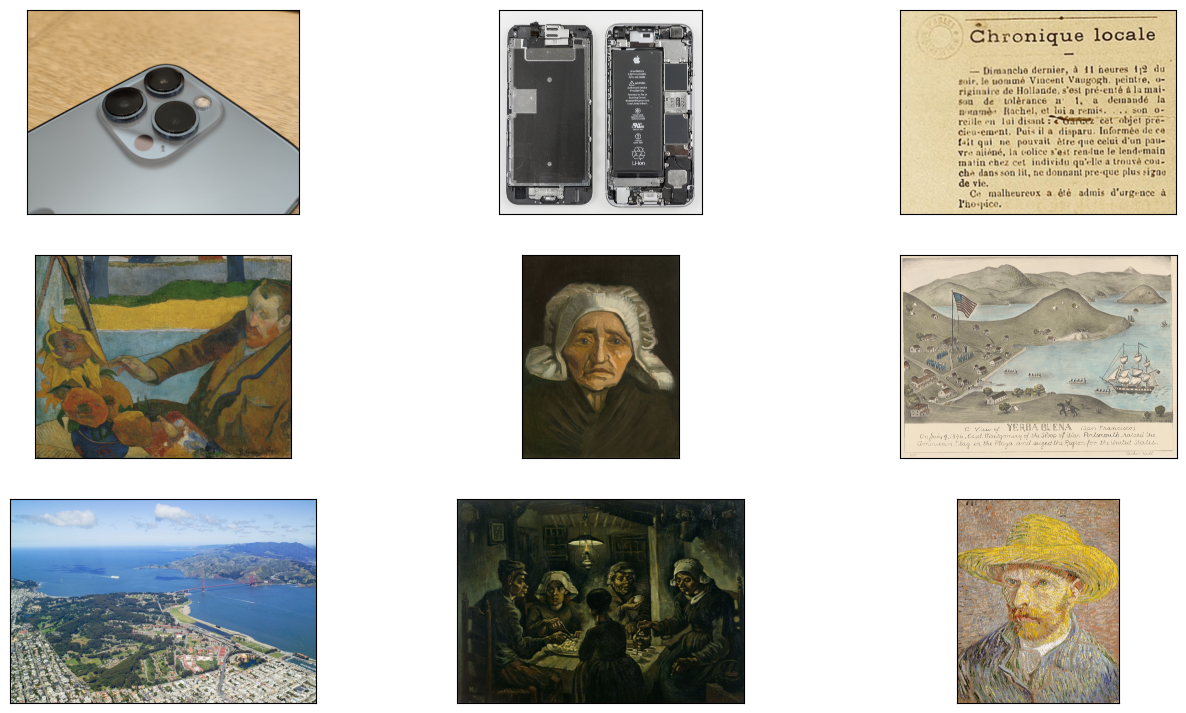

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import os

image_paths = []
for img_path in os.listdir("./mixed_wiki"):
    image_paths.append(str(os.path.join("./mixed_wiki", img_path)))


def plot_images(image_paths):
    images_shown = 0
    plt.figure(figsize=(16, 9))
    for img_path in image_paths:
        if os.path.isfile(img_path):
            image = Image.open(img_path)

            plt.subplot(3, 3, images_shown + 1)
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])

            images_shown += 1
            if images_shown >= 9:
                break


plot_images(image_paths)

## Build Multi-Modal index and Vector Store to index both text and images from Wikipedia

In [ ]:
from llama_index.indices.multi_modal.base import MultiModalVectorStoreIndex
from llama_index.vector_stores import QdrantVectorStore
from llama_index import SimpleDirectoryReader, StorageContext

import qdrant_client
from llama_index import (
    SimpleDirectoryReader,
)


# Create a local Qdrant vector store
client = qdrant_client.QdrantClient(path="qdrant_img_db")

text_store = QdrantVectorStore(
    client=client, collection_name="text_collection"
)
image_store = QdrantVectorStore(
    client=client, collection_name="image_collection"
)
storage_context = StorageContext.from_defaults(vector_store=text_store)

# Create the MultiModal index
documents = SimpleDirectoryReader("./mixed_wiki/").load_data()
index = MultiModalVectorStoreIndex.from_documents(
    documents, storage_context=storage_context, image_vector_store=image_store
)

## Plot input query image

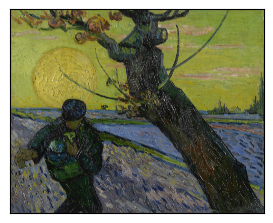

In [ ]:
input_image = "./mixed_wiki/2.jpg"
plot_images([input_image])

## Retrieve images from Multi-Modal Index given the image query

### 1. Image to Image Retrieval Results

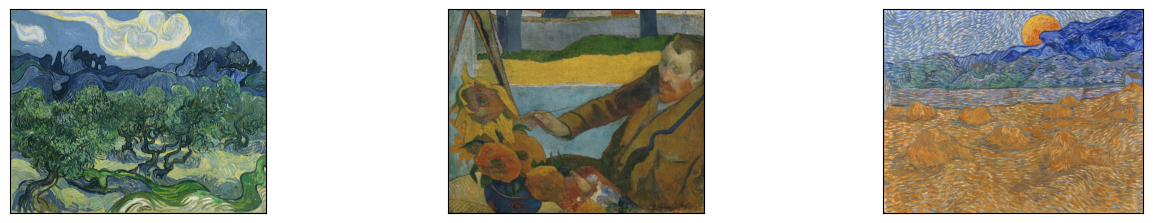

In [ ]:
# generate Text retrieval results
retriever_engine = index.as_retriever(image_similarity_top_k=4)
# retrieve more information from the GPT4V response
retrieval_results = retriever_engine.image_to_image_retrieve(
    "./mixed_wiki/2.jpg"
)
retrieved_images = []
for res in retrieval_results:
    retrieved_images.append(res.node.metadata["file_path"])

# Remove the first retrieved image as it is the input image
# since the input image will gethe highest similarity score
plot_images(retrieved_images[1:])

### 2. GPT4V Reasoning Retrieved Images based on Input Image

In [ ]:
from llama_index.multi_modal_llms.openai import OpenAIMultiModal
from llama_index import SimpleDirectoryReader
from llama_index.schema import ImageDocument

# put your local directore here
image_documents = [ImageDocument(image_path=input_image)]

for res_img in retrieved_images[1:]:
    image_documents.append(ImageDocument(image_path=res_img))


openai_mm_llm = OpenAIMultiModal(
    model="gpt-4-vision-preview", api_key=OPENAI_API_TOKEN, max_new_tokens=1500
)
response = openai_mm_llm.complete(
    prompt="Given the first image as the base image, what the other images correspond to?",
    image_documents=image_documents,
)

print(response)

The images you've provided appear to be paintings that are consistent with the style of Vincent van Gogh, a renowned post-impressionist artist. Although I can't provide the titles or verify the authenticity of the images, here is how each image corresponds to the first, based on their style and content:

1. The first image shows a figure, possibly a farmer, leaning on a spade with a large sun in the background. It is characteristic of van Gogh's vivid color palette and expressive brushwork.

2. The second image is a landscape with olive trees and swirling clouds in the sky, which reflects van Gogh's fascination with the natural environment and his unique interpretation of it.

3. The third image is a portrait that includes a vase with sunflowers, a subject van Gogh is famously known for painting. It also reflects his distinctive brushwork and use of color.

4. The fourth image is another landscape, featuring a field with haystacks at twilight or early morning, with a large, brightly co